# Remote catalog

In [2]:
import intake

In [3]:
# for caching into specific folder
import fsspec
fsspec.config.conf['simplecache']={'cache_storage': 'my_caching_folder'}

In [14]:
cat = intake.open_catalog('https://raw.githubusercontent.com/aaronspring/remote_climate_data/master/master.yaml')
# instead open catalog file locally
# mistral compute nodes have no network connection
cat = intake.open_catalog('../master.yaml')
list(cat)

['ocean', 'land', 'atmosphere', 'climate', 'shapefiles', 'regionmask']

# load datasets to `xarray` with `dask`

In [15]:
list(cat.atmosphere)

['HadCRUT4', 'CRU_TS']

In [16]:
# available metadata before any file loading 
cat.atmosphere.HadCRUT4.discover()

{'dtype': None,
 'shape': None,
 'npartitions': None,
 'metadata': {'url': 'https://crudata.uea.ac.uk/cru/data/temperature/',
  'doi': '10.1029/2011JD017187',
  'plots': {'temperature_anomaly_over_time': {'title': 'HadCRUT4 temperature anomly wrt. 1960-1989',
    'kind': 'contourf',
    'x': 'longitude',
    'y': 'latitude',
    'z': 'temperature_anomaly',
    'ylim': [-90, 90],
    'xlim': [-180, 180],
    'groupby': 'time',
    'label': 'Temperature Anomaly [K]',
    'cmap': 'RdBu_r',
    'levels': 20},
   'GMSTa': {'title': 'Global mean surface temperature anomaly wrt. 1960-1989',
    'kind': 'line',
    'x': 'time',
    'y': 'temperature_anomaly'}},
  'catalog_dir': '/Users/aaron.spring/Coding/remote_climate_data/notebooks/../catalogs/',
  'dims': {'latitude': 36, 'longitude': 72, 'time': 2049},
  'data_vars': {'temperature_anomaly': ['latitude', 'longitude', 'time'],
   'field_status': ['time']},
  'coords': ('latitude', 'longitude', 'time'),
  'title': 'HadCRUT4 near-surface temp

In [17]:
# to_dask() returns chunked xr.Dataset
ds = cat.atmosphere.HadCRUT4.to_dask()
ds

<xarray.Dataset>
Dimensions:              (latitude: 36, longitude: 72, time: 2049)
Coordinates:
  * latitude             (latitude) float32 -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * longitude            (longitude) float32 -177.5 -172.5 ... 172.5 177.5
  * time                 (time) object 1850-01-16 12:00:00 ... 2020-09-16 00:...
Data variables:
    temperature_anomaly  (time, latitude, longitude) float32 dask.array<chunksize=(2049, 36, 72), meta=np.ndarray>
    field_status         (time) |S1 dask.array<chunksize=(2049,), meta=np.ndarray>
Attributes:
    title:                  HadCRUT4 near-surface temperature ensemble data -...
    institution:            Met Office Hadley Centre / Climatic Research Unit...
    history:                Updated at 27/10/2020 11:20:18
    source:                 CRUTEM.4.6.0.0, HadSST.3.1.1.0
    comment:                
    reference:              Morice, C. P., J. J. Kennedy, N. A. Rayner, and P...
    version:                HadCRUT.4.6.0.0
    Conventions:            CF-1.0
    ensemble_members:       100
    ensemble_member_index:  0

In [23]:
# dataset cached locally
import os
assert 'HadCRUT.4.6.0.0.median.nc' in os.listdir('my_caching_folder')

# access pre-defined plots

`intake` allows to pre-define plots that any other user using this catalog can access. This makes basic plot sharing very easy.

In [8]:
cat.atmosphere.HadCRUT4.plots

['temperature_anomaly_over_time', 'GMSTa']

In [9]:
# requires hvplot.xarray
import hvplot.xarray

In [10]:
cat.atmosphere.HadCRUT4.plot.temperature_anomaly_over_time().opts(clim=(-5,5))

/Users/aaron.spring/anaconda3/envs/remote_climate_data-dev/lib/python3.6/site-packages/holoviews/plotting/util.py:685: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  [cmap for cmap in cm.cmap_d if not
/Users/aaron.spring/anaconda3/envs/remote_climate_data-dev/lib/python3.6/site-packages/holoviews/plotting/util.py:685: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  [cmap for cmap in cm.cmap_d if not


/Users/aaron.spring/anaconda3/envs/remote_climate_data-dev/lib/python3.6/site-packages/holoviews/plotting/util.py:685: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  [cmap for cmap in cm.cmap_d if not


:DynamicMap   [time]
   :Polygons   [longitude,latitude]   (temperature_anomaly)

# spatial aggregation within shapefile regions with `regionmask`

`geopandas` opens shapefiles (ending `.zip` or extracted `.shp`). `intake_geopandas` allows catalog access and caching of these.

`regionmask` aggregates values within boundaries defined by shapefiles. This even works for curvilinear grids.
https://regionmask.readthedocs.io/en/stable/

In [11]:
import regionmask
gdf = cat.shapefiles.Countries.read()
# initialize regionmask.region from geopandas
region = regionmask.from_geopandas(gdf, names='NAME_EN', abbrevs='_from_name')

In [12]:
# or short via intake_regionmask
region = cat.regionmask.Countries.read()
region

<regionmask.Regions>
Name:     unnamed

Regions:
   0          Ind0                    Indonesia
   1          Mal0                     Malaysia
   2           Chi                        Chile
   3           Bol                      Bolivia
   4           Per                         Peru
...            ...                          ...
 250           Mac                        Macau
 251  AshandCarIsl  Ashmore and Cartier Islands
 252     BajNueBan              Bajo Nuevo Bank
 253        SerBan              Serranilla Bank
 254        ScaSho            Scarborough Shoal

[255 regions]

<GeoAxesSubplot:>

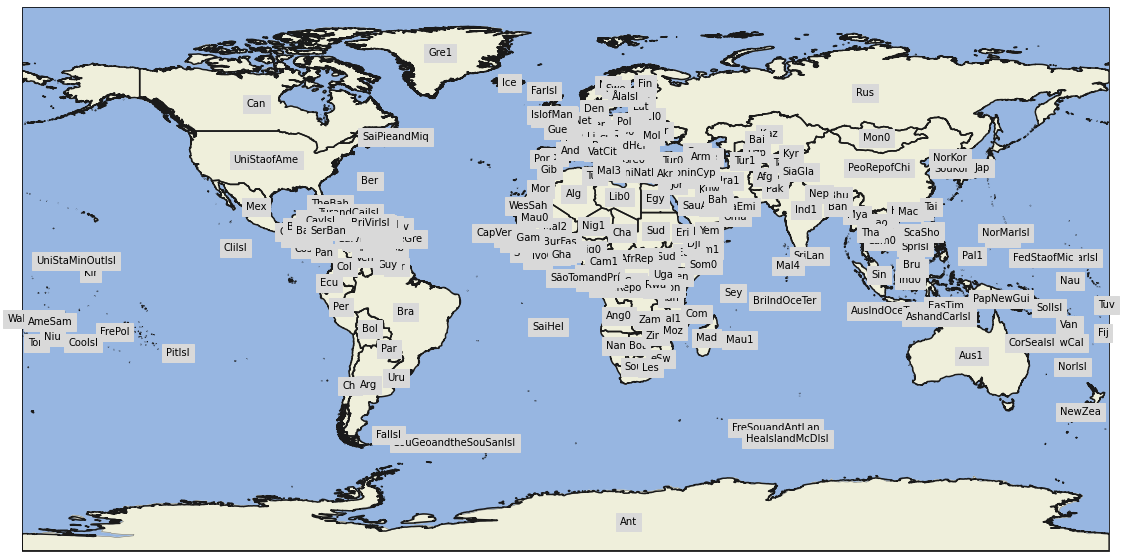

In [13]:
import matplotlib.pyplot as plt
# increase region figsize
fig,ax = plt.subplots(figsize=(25,10))
region.plot(label='abbrev',add_land=True, add_ocean=True)

In [14]:
# load a data product
ds = cat.atmosphere.HadCRUT4.to_dask()

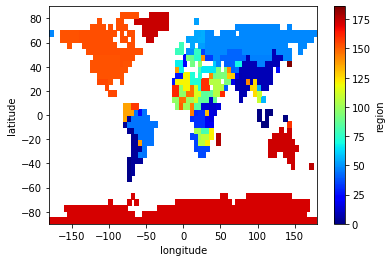

In [15]:
# get a mask of shapefile regions based on ds grid
mask = region.mask(ds, lon_name='longitude',lat_name='latitude')

mask.plot(cmap='jet')

In [16]:
# aggregate mean temperature per country
tsurfc = ds.groupby(mask).mean('stacked_latitude_longitude')

In [17]:
def set_regionmask_labels(ds, region):
    """Set names as region label for region dimension from regionmask regions."""
    abbrevs = region[ds.region.values].abbrevs
    names = region[ds.region.values].names
    ds.coords["abbrevs"] = ("region", abbrevs)
    ds.coords["number"] = ("region", ds.region.values)
    ds["region"] = names
    return ds

tsurfc = set_regionmask_labels(tsurfc, region)
tsurfc.coords

Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2020-07-16 12:00:00
  * region   (region) <U32 'Indonesia' 'Malaysia' ... 'Madagascar' 'Japan'
    abbrevs  (region) <U14 'Ind0' 'Mal0' 'Chi' 'Bol' ... 'NewZea' 'Mad' 'Jap'
    number   (region) float64 0.0 1.0 2.0 3.0 4.0 ... 174.0 176.0 178.0 186.0

/Users/aaron.spring/anaconda3/envs/remote_climate_data-dev/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


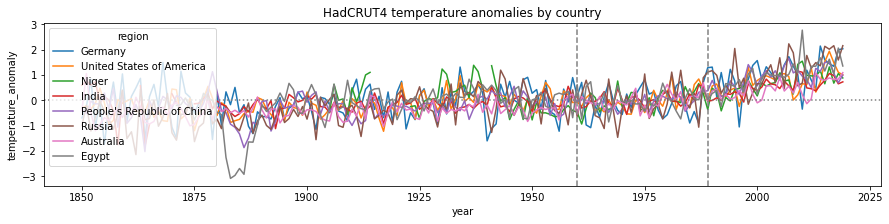

In [18]:
# plot yearmean until 2019 temperature record per country
regions = ['Germany','United States of America','Niger','India',"People's Republic of China",'Russia','Australia','Egypt']
tsurfc.sel(region=regions).sel(time=slice(None,'2019')).groupby('time.year').mean().temperature_anomaly.plot(hue='region',figsize=(15,3))
plt.title('HadCRUT4 temperature anomalies by country')
plt.axhline(y=0,c='gray',ls=':')
plt.axvline(x=1960,c='gray',ls='--')
plt.axvline(x=1989,c='gray',ls='--')
plt.show()